In [ ]:
# The link for the AI chat: https://gemini.google.com/share/2fda3084b5e7

--- Bonferroni Correction Applied ---
Total Number of Tests (Genres): 21
Original Significance Level (Alpha): 0.05
Corrected Significance Level: 0.002381
(A result is statistically significant only if P-Value < Corrected Alpha)

--- Genre Analysis: Fisher's Exact Test Results ---

Genre           | Win Rate   | P-Value    | Significant?
-----------------------------------------------------------------
Western         | 50.0%     | 0.114801     | No
Thriller        | 25.0%     | 0.157882     | No
Mystery         | 0.0%     | 0.219232     | No
Musical         | 33.3%     | 0.399329     | No
History         | 19.2%     | 0.565170     | No
Sport           | 20.0%     | 0.574462     | No
Crime           | 18.8%     | 0.595786     | No
Music           | 0.0%     | 0.612569     | No
Fantasy         | 8.3%     | 0.695554     | No
Drama           | 16.1%     | 0.695859     | No
Action          | 10.5%     | 0.743107     | No
Adventure       | 11.1%     | 0.774144     | No
Comedy          | 13.2

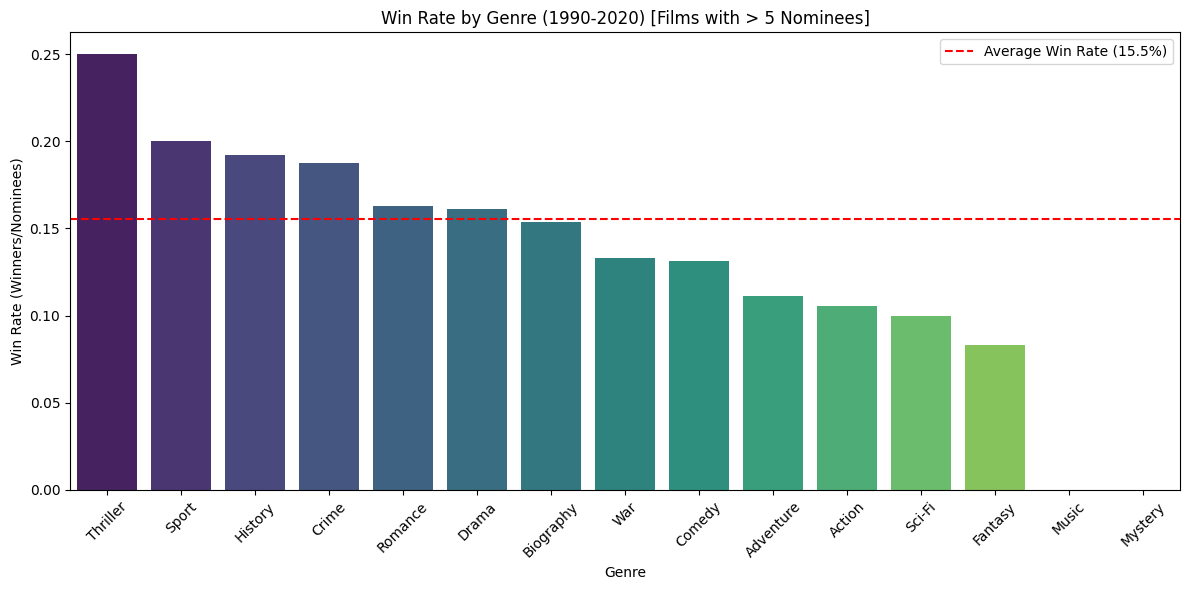

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
import io
import warnings

# --- 0. Setup & Warning Suppression ---
# This ignores FutureWarning messages for cleaner output
warnings.simplefilter(action='ignore', category=FutureWarning)

# --- 1. Data Loading and Robust Cleaning ---
# This block ensures the CSV is read correctly even if it has formatting errors
try:
    with open('Final_best_picture_data.csv', 'r') as f:
        lines = f.readlines()

    cleaned_lines = []
    for line in lines:
        line = line.strip()
        if not line: continue
        # Fix rows wrapped entirely in quotes (common CSV error)
        if line.startswith('"') and line.endswith('"'):
            content = line[1:-1].replace('""', '"') # Remove outer quotes and unescape inner ones
            cleaned_lines.append(content)
        else:
            cleaned_lines.append(line)

    # Create DataFrame from cleaned string content
    df = pd.read_csv(io.StringIO("\n".join(cleaned_lines)))
except FileNotFoundError:
    print("Error: 'Final_best_picture_data.csv' not found. Please upload the file.")
    df = pd.DataFrame()

if not df.empty:
    # --- 2. Preprocessing ---
    # Convert year and winner columns
    df['year_ceremony'] = pd.to_numeric(df['year_ceremony'], errors='coerce')
    df['winner'] = df['winner'].astype(str).str.lower() == 'true'

    # Filter for the analysis period (1990-2020)
    df_analysis = df[(df['year_ceremony'] >= 1990) & (df['year_ceremony'] <= 2020)].copy()

    # Process Genres (split comma-separated strings into lists)
    # e.g., "Drama, Crime" -> ["Drama", "Crime"]
    df_analysis['Genre_List'] = df_analysis['Genre'].astype(str).str.split(',')
    df_analysis['Genre_List'] = df_analysis['Genre_List'].apply(lambda x: [g.strip() for g in x])

    # --- 3. Genre Analysis with Bonferroni Correction ---

    # Get set of all unique genres present in the dataset
    all_genres = set([g for sublist in df_analysis['Genre_List'] for g in sublist])

    # === Bonferroni Correction Step ===
    # Since we are testing multiple hypotheses (one for each genre),
    # we must adjust our significance level (alpha) to avoid false positives.
    num_tests = len(all_genres)
    original_alpha = 0.05
    corrected_alpha = original_alpha / num_tests  # e.g. 0.05 / 20 = 0.0025

    print(f"--- Bonferroni Correction Applied ---")
    print(f"Total Number of Tests (Genres): {num_tests}")
    print(f"Original Significance Level (Alpha): {original_alpha}")
    print(f"Corrected Significance Level: {corrected_alpha:.6f}")
    print("(A result is statistically significant only if P-Value < Corrected Alpha)\n")

    results = []

    print(f"--- Genre Analysis: Fisher's Exact Test Results ---\n")
    print(f"{'Genre':<15} | {'Win Rate':<10} | {'P-Value':<10} | {'Significant?'}")
    print("-" * 65)

    for genre in all_genres:
        # Create binary feature for the current genre (1 if movie is this genre, 0 otherwise)
        df_analysis[f'is_{genre}'] = df_analysis['Genre_List'].apply(lambda x: genre in x)

        # Contingency Table Construction
        #           Win   Not Win
        # Has Genre  a      b
        # No Genre   c      d
        has_genre_winners = len(df_analysis[(df_analysis[f'is_{genre}']) & (df_analysis['winner'])])
        has_genre_losers = len(df_analysis[(df_analysis[f'is_{genre}']) & (~df_analysis['winner'])])
        no_genre_winners = len(df_analysis[(~df_analysis[f'is_{genre}']) & (df_analysis['winner'])])
        no_genre_losers = len(df_analysis[(~df_analysis[f'is_{genre}']) & (~df_analysis['winner'])])

        table = [[has_genre_winners, has_genre_losers],
                 [no_genre_winners, no_genre_losers]]

        # Perform Fisher's Exact Test
        odds_ratio, p_value = fisher_exact(table, alternative='two-sided')

        # Calculate stats for reporting
        total_in_genre = has_genre_winners + has_genre_losers
        win_rate = has_genre_winners / total_in_genre if total_in_genre > 0 else 0

        # Determine significance based on the CORRECTED alpha
        is_significant = p_value < corrected_alpha
        significance_text = "YES (*)" if is_significant else "No"

        results.append({
            'Genre': genre,
            'P-Value': p_value,
            'Odds Ratio': odds_ratio,
            'Win Rate': win_rate,
            'Total Films': total_in_genre,
            'Significant': is_significant,
            'Significance_Text': significance_text
        })

    # Convert results to DataFrame for sorting and easier plotting
    results_df = pd.DataFrame(results).sort_values(by='P-Value')

    # Print table rows (sorted by p-value)
    for index, row in results_df.iterrows():
        print(f"{row['Genre']:<15} | {row['Win Rate']:.1%}     | {row['P-Value']:.6f}     | {row['Significance_Text']}")

    # --- 4. Final Conclusion Printing ---
    print("\n" + "="*30)
    print("FINAL CONCLUSION FOR GENRE ANALYSIS")
    print("="*30)

    significant_genres = results_df[results_df['Significant'] == True]

    if len(significant_genres) > 0:
        print(f"We REJECT the Null Hypothesis for the following genres (p < {corrected_alpha:.6f}):")
        for idx, row in significant_genres.iterrows():
            print(f"- {row['Genre']} (Win Rate: {row['Win Rate']:.1%}, p={row['P-Value']:.6f})")
        print("\nThese genres show a statistically significant association with winning/losing even after correction.")
    else:
        print(f"We FAIL TO REJECT the Null Hypothesis for ALL genres after applying Bonferroni correction.")
        print(f"No single genre had a p-value lower than the corrected threshold of {corrected_alpha:.6f}.")
        print("Interpretation: While some genres might look like they win more often, statistically we cannot prove it isn't just luck/random chance given the number of genres we tested.")

    # --- 5. Visualization ---
    # Filter for genres with reasonable sample size (> 5 films) to keep plot clean
    viz_df = results_df[results_df['Total Films'] >= 5].sort_values(by='Win Rate', ascending=False)

    plt.figure(figsize=(12, 6))

    # Create Bar Plot
    # Hue is mapped to 'Genre' to assign colors, legend=False hides the redundant legend
    sns.barplot(data=viz_df, x='Genre', y='Win Rate', hue='Genre', palette='viridis', legend=False)

    plt.title('Win Rate by Genre (1990-2020) [Films with > 5 Nominees]')
    plt.xticks(rotation=45)
    plt.ylabel('Win Rate (Winners/Nominees)')
    plt.xlabel('Genre')

    # Add a line for the average win rate of all films
    avg_win_rate = df_analysis['winner'].mean()
    plt.axhline(y=avg_win_rate, color='r', linestyle='--', label=f'Average Win Rate ({avg_win_rate:.1%})')
    plt.legend()

    plt.tight_layout()
    plt.show()

PART 1: RUNTIME T-TEST (Winners vs Non-Winners)
Winners Mean Runtime: 137.77 min
Losers Mean Runtime:  129.94 min
Difference:           7.82 min
T-Statistic:          1.4827
P-Value:              0.1467
CONCLUSION: FAIL TO REJECT H0. There is NO statistically significant difference in runtime.


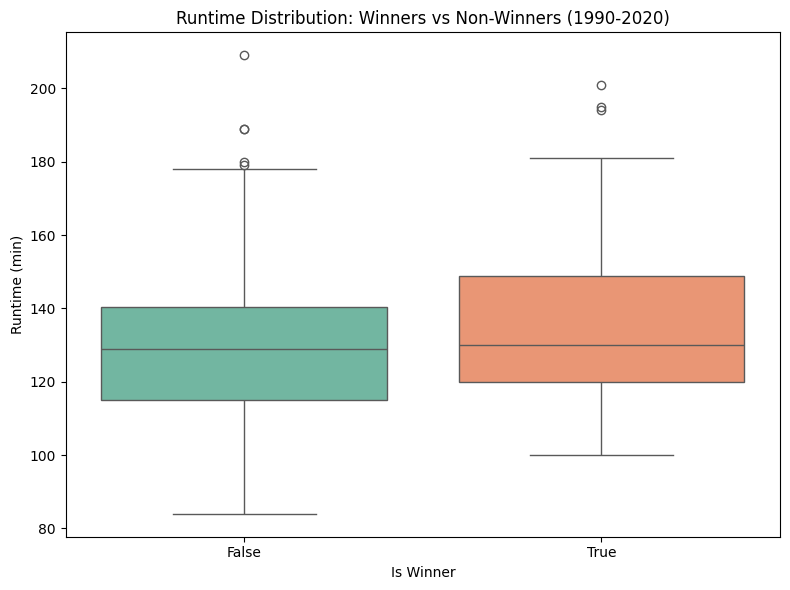


PART 2: BINNED RUNTIME ANALYSIS (10-min Intervals)
--- Bonferroni Correction Applied ---
Number of Bins Tested: 13
Original Alpha: 0.05
Corrected Alpha: 0.003846 (Threshold for significance)

Bin Range       | Win Rate   | P-Value    | Significant?
-----------------------------------------------------------------
[80, 90)        | 0.0%     | 1.000000   | No
[90, 100)       | 0.0%     | 0.226088   | No
[100, 110)      | 5.3%     | 0.317641   | No
[110, 120)      | 21.4%     | 0.396622   | No
[120, 130)      | 19.4%     | 0.453108   | No
[130, 140)      | 15.9%     | 1.000000   | No
[140, 150)      | 7.1%     | 0.700365   | No
[150, 160)      | 14.3%     | 1.000000   | No
[160, 170)      | 10.0%     | 1.000000   | No
[170, 180)      | 16.7%     | 1.000000   | No
[180, 190)      | 25.0%     | 0.494172   | No
[190, 200)      | 100.0%     | 0.023478   | No
[200, 210)      | 50.0%     | 0.287403   | No

FINAL CONCLUSION (Binned Analysis)
After applying Bonferroni correction (p < 0.003846), 

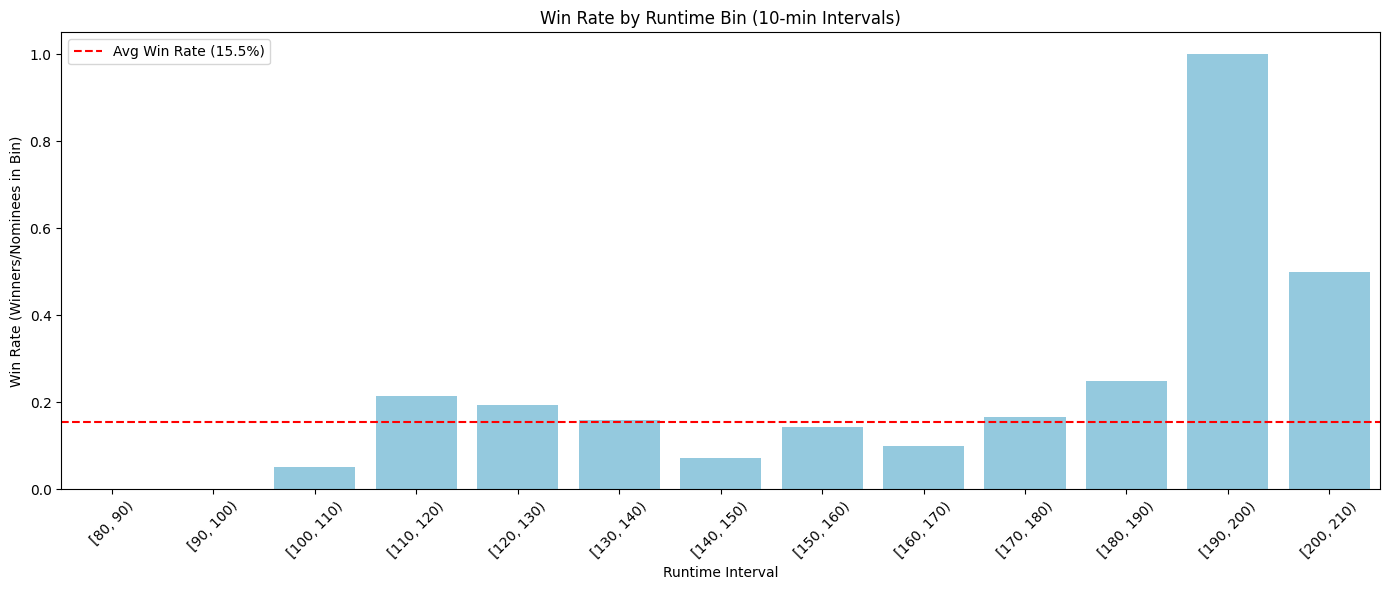

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, fisher_exact
import io
import warnings

# --- 0. Setup ---
# Suppress warnings to keep output clean
warnings.filterwarnings("ignore")

# --- 1. Data Loading and Robust Cleaning ---
# This ensures the CSV is read correctly even with formatting errors
try:
    with open('Final_best_picture_data.csv', 'r') as f:
        lines = f.readlines()

    cleaned_lines = []
    for line in lines:
        line = line.strip()
        if not line: continue
        # Fix rows wrapped entirely in quotes (common CSV error)
        if line.startswith('"') and line.endswith('"'):
            content = line[1:-1].replace('""', '"')
            cleaned_lines.append(content)
        else:
            cleaned_lines.append(line)

    df = pd.read_csv(io.StringIO("\n".join(cleaned_lines)))
except FileNotFoundError:
    print("Error: 'Final_best_picture_data.csv' not found. Please upload the file.")
    df = pd.DataFrame()

if not df.empty:
    # --- 2. Preprocessing ---
    # Convert year and winner columns
    df['year_ceremony'] = pd.to_numeric(df['year_ceremony'], errors='coerce')
    df['winner'] = df['winner'].astype(str).str.lower() == 'true'

    # Filter for the analysis period (1990-2020)
    df_analysis = df[(df['year_ceremony'] >= 1990) & (df['year_ceremony'] <= 2020)].copy()

    # Parse Runtime (e.g., "142 min" -> 142) and handle errors
    df_analysis['Runtime_Num'] = df_analysis['Runtime'].astype(str).str.replace(' min', '', regex=False)
    df_analysis['Runtime_Num'] = pd.to_numeric(df_analysis['Runtime_Num'], errors='coerce')

    # Drop rows where Runtime is NaN
    df_analysis = df_analysis.dropna(subset=['Runtime_Num'])

    # --- PART 1: T-Test Analysis (Overall Difference) ---
    winners_runtime = df_analysis[df_analysis['winner']]['Runtime_Num']
    losers_runtime = df_analysis[~df_analysis['winner']]['Runtime_Num']

    # Perform Independent T-Test (assuming unequal variance due to sample size difference)
    t_stat, p_val_ttest = ttest_ind(winners_runtime, losers_runtime, equal_var=False)

    print("==================================================")
    print("PART 1: RUNTIME T-TEST (Winners vs Non-Winners)")
    print("==================================================")
    print(f"Winners Mean Runtime: {winners_runtime.mean():.2f} min")
    print(f"Losers Mean Runtime:  {losers_runtime.mean():.2f} min")
    print(f"Difference:           {winners_runtime.mean() - losers_runtime.mean():.2f} min")
    print(f"T-Statistic:          {t_stat:.4f}")
    print(f"P-Value:              {p_val_ttest:.4f}")

    if p_val_ttest < 0.05:
        print("CONCLUSION: REJECT H0. There IS a statistically significant difference in runtime between winners and losers.")
    else:
        print("CONCLUSION: FAIL TO REJECT H0. There is NO statistically significant difference in runtime.")

    # Visualization 1: Boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='winner', y='Runtime_Num', data=df_analysis, palette='Set2')
    plt.title('Runtime Distribution: Winners vs Non-Winners (1990-2020)')
    plt.xlabel('Is Winner')
    plt.ylabel('Runtime (min)')
    plt.tight_layout()
    plt.show()

    # --- PART 2: Binned Analysis with Bonferroni Correction ---

    # Create bins dynamically based on min/max runtime to ensure all films are covered
    min_r = int(df_analysis['Runtime_Num'].min())
    max_r = int(df_analysis['Runtime_Num'].max())

    # Align bins to nearest 10 (e.g., 80, 90, 100...)
    start = (min_r // 10) * 10
    end = ((max_r // 10) + 1) * 10
    bins = range(start, end + 10, 10)

    # Cut the data into 10-minute bins
    df_analysis['Runtime_Bin'] = pd.cut(df_analysis['Runtime_Num'], bins=bins, right=False)
    unique_bins = sorted(df_analysis['Runtime_Bin'].dropna().unique())

    # === Bonferroni Correction Step ===
    # We are testing multiple time intervals (bins).
    # To avoid random false positives, we divide alpha by the number of bins.
    num_tests = len(unique_bins)
    original_alpha = 0.05
    corrected_alpha = original_alpha / num_tests

    print("\n==================================================")
    print("PART 2: BINNED RUNTIME ANALYSIS (10-min Intervals)")
    print("==================================================")
    print(f"--- Bonferroni Correction Applied ---")
    print(f"Number of Bins Tested: {num_tests}")
    print(f"Original Alpha: {original_alpha}")
    print(f"Corrected Alpha: {corrected_alpha:.6f} (Threshold for significance)\n")

    print(f"{'Bin Range':<15} | {'Win Rate':<10} | {'P-Value':<10} | {'Significant?'}")
    print("-" * 65)

    bin_results = []

    for r_bin in unique_bins:
        bin_label = str(r_bin)

        # Create binary feature for this specific bin
        df_analysis['in_bin'] = df_analysis['Runtime_Bin'] == r_bin

        # Contingency Table Construction
        #           Win   Lose
        # In Bin     a      b
        # Out Bin    c      d
        in_bin_win = len(df_analysis[(df_analysis['in_bin']) & (df_analysis['winner'])])
        in_bin_lose = len(df_analysis[(df_analysis['in_bin']) & (~df_analysis['winner'])])
        out_bin_win = len(df_analysis[(~df_analysis['in_bin']) & (df_analysis['winner'])])
        out_bin_lose = len(df_analysis[(~df_analysis['in_bin']) & (~df_analysis['winner'])])

        table = [[in_bin_win, in_bin_lose],
                 [out_bin_win, out_bin_lose]]

        # Perform Fisher's Exact Test
        odds, p_val = fisher_exact(table, alternative='two-sided')

        # Calculate stats for reporting
        total_in_bin = in_bin_win + in_bin_lose
        win_rate = in_bin_win / total_in_bin if total_in_bin > 0 else 0

        # Determine significance based on CORRECTED alpha
        is_significant = p_val < corrected_alpha
        significance_text = "YES (*)" if is_significant else "No"

        bin_results.append({
            'Bin': bin_label,
            'Win Rate': win_rate,
            'P-Value': p_val,
            'Significant': is_significant
        })

        print(f"{bin_label:<15} | {win_rate:.1%}     | {p_val:.6f}   | {significance_text}")

    # --- Conclusion for Binned Analysis ---
    print("\n" + "="*30)
    print("FINAL CONCLUSION (Binned Analysis)")
    print("="*30)

    significant_bins = [res for res in bin_results if res['Significant']]

    if len(significant_bins) > 0:
        print(f"After applying Bonferroni correction (p < {corrected_alpha:.6f}), the following runtime ranges are significantly associated with winning/losing:")
        for res in significant_bins:
            print(f"- {res['Bin']} (Win Rate: {res['Win Rate']:.1%})")
    else:
        print(f"After applying Bonferroni correction (p < {corrected_alpha:.6f}), NO specific 10-minute interval showed a statistically significant advantage.")
        print("This implies that while the average runtime might differ, no specific 'magic duration' guarantees a win statistically.")

    # Visualization 2: Barplot of Win Rates
    bin_res_df = pd.DataFrame(bin_results)

    plt.figure(figsize=(14, 6))
    sns.barplot(data=bin_res_df, x='Bin', y='Win Rate', color='skyblue')
    plt.title('Win Rate by Runtime Bin (10-min Intervals)')
    plt.xticks(rotation=45)
    plt.ylabel('Win Rate (Winners/Nominees in Bin)')
    plt.xlabel('Runtime Interval')

    # Add average line
    avg_win_rate = df_analysis['winner'].mean()
    plt.axhline(y=avg_win_rate, color='r', linestyle='--', label=f'Avg Win Rate ({avg_win_rate:.1%})')
    plt.legend()

    plt.tight_layout()
    plt.show()

PART 1: METASCORE T-TEST (Winners vs Non-Winners)
Winners Mean Score:   84.33
Losers Mean Score:    80.33
Difference:           4.01 points
T-Statistic:          2.0773
P-Value:              0.043336
CONCLUSION: REJECT H0. There IS a statistically significant difference in Metascores between winners and losers.


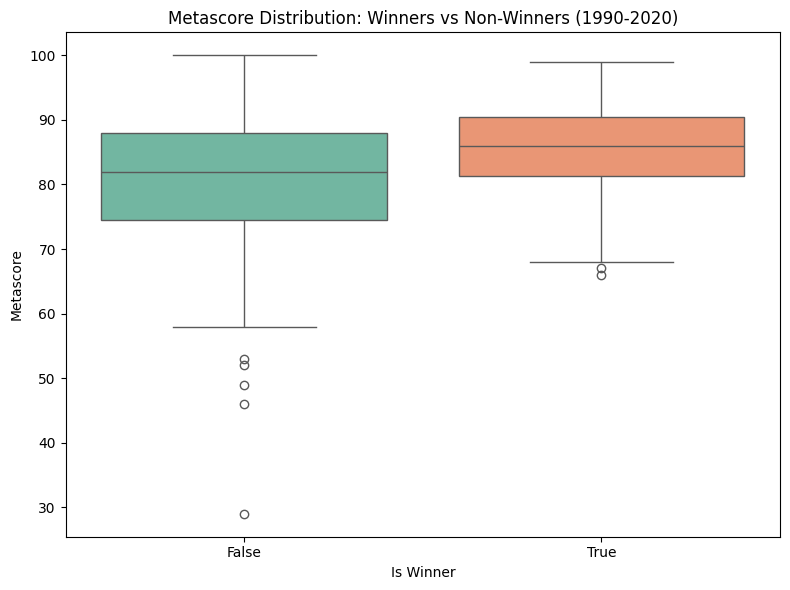


PART 2: BINNED METASCORE ANALYSIS (10-point Intervals)
--- Bonferroni Correction Applied ---
Number of Bins Tested: 8
Original Alpha: 0.05
Corrected Alpha: 0.006250 (Threshold for significance)

Score Range     | Win Rate   | P-Value    | Significant?
-----------------------------------------------------------------
[20, 30)        | 0.0%     | 1.000000   | No
[40, 50)        | 0.0%     | 1.000000   | No
[50, 60)        | 0.0%     | 0.598380   | No
[60, 70)        | 21.1%     | 0.505104   | No
[70, 80)        | 8.1%     | 0.211443   | No
[80, 90)        | 17.9%     | 0.548331   | No
[90, 100)       | 19.0%     | 0.476168   | No
[100, 110)      | 0.0%     | 1.000000   | No

FINAL CONCLUSION (Binned Analysis)
After applying Bonferroni correction (p < 0.006250), NO specific score range showed a statistically significant effect alone.
This suggests that while higher scores generally help (as seen in T-Test), falling into a specific 'bucket' isn't the sole determinant.


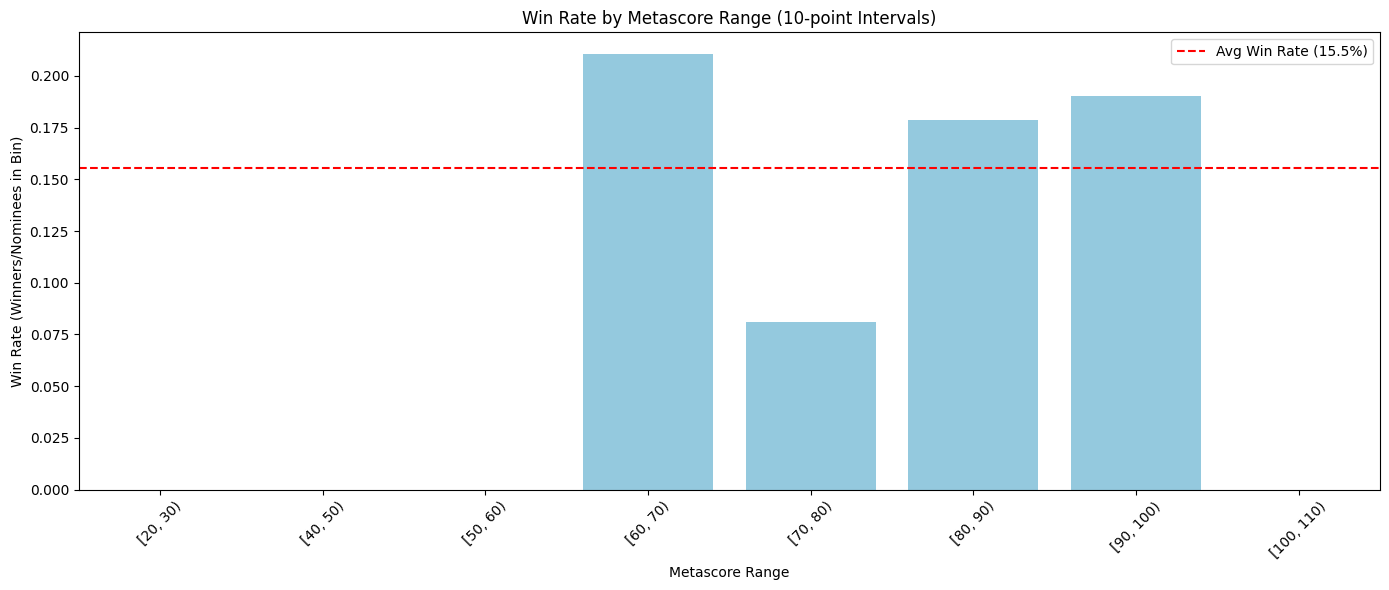

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, fisher_exact
import io
import warnings

# --- 0. Setup ---
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# --- 1. Data Loading and Robust Cleaning ---
# This block handles potential CSV formatting errors (quoted rows)
try:
    with open('Final_best_picture_data.csv', 'r') as f:
        lines = f.readlines()

    cleaned_lines = []
    for line in lines:
        line = line.strip()
        if not line: continue
        # Fix rows wrapped entirely in quotes
        if line.startswith('"') and line.endswith('"'):
            content = line[1:-1].replace('""', '"')
            cleaned_lines.append(content)
        else:
            cleaned_lines.append(line)

    df = pd.read_csv(io.StringIO("\n".join(cleaned_lines)))
except FileNotFoundError:
    print("Error: 'Final_best_picture_data.csv' not found. Please upload the file.")
    df = pd.DataFrame()

if not df.empty:
# --- 2. Preprocessing ---
    # Convert year and winner columns
    df['year_ceremony'] = pd.to_numeric(df['year_ceremony'], errors='coerce')
    df['winner'] = df['winner'].astype(str).str.lower() == 'true'

    # Filter for the analysis period (1990-2020)
    df_analysis = df[(df['year_ceremony'] >= 1990) & (df['year_ceremony'] <= 2020)].copy()

    # Process Meta_score (Ensure it is numeric)
    df_analysis['Meta_score'] = pd.to_numeric(df_analysis['Meta_score'], errors='coerce')

    # Drop rows where Meta_score is missing
    df_analysis = df_analysis.dropna(subset=['Meta_score'])

    # --- PART 1: T-Test Analysis (Overall Score Difference) ---
    # We compare the mean score of Winners vs. Losers
    winners_score = df_analysis[df_analysis['winner']]['Meta_score']
    losers_score = df_analysis[~df_analysis['winner']]['Meta_score']

    # Perform Independent T-Test (assuming unequal variance)
    t_stat, p_val_ttest = ttest_ind(winners_score, losers_score, equal_var=False)

    print("==================================================")
    print("PART 1: METASCORE T-TEST (Winners vs Non-Winners)")
    print("==================================================")
    print(f"Winners Mean Score:   {winners_score.mean():.2f}")
    print(f"Losers Mean Score:    {losers_score.mean():.2f}")
    print(f"Difference:           {winners_score.mean() - losers_score.mean():.2f} points")
    print(f"T-Statistic:          {t_stat:.4f}")
    print(f"P-Value:              {p_val_ttest:.6f}")

    if p_val_ttest < 0.05:
        print("CONCLUSION: REJECT H0. There IS a statistically significant difference in Metascores between winners and losers.")
    else:
        print("CONCLUSION: FAIL TO REJECT H0. There is NO statistically significant difference in Metascores.")

    # Visualization 1: Boxplot (Distribution)
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='winner', y='Meta_score', data=df_analysis, palette='Set2')
    plt.title('Metascore Distribution: Winners vs Non-Winners (1990-2020)')
    plt.xlabel('Is Winner')
    plt.ylabel('Metascore')
    plt.tight_layout()
    plt.show()

    # --- PART 2: Binned Analysis with Bonferroni Correction ---
    # We split scores into bins (e.g., 60-70, 70-80...) to see if a specific range guarantees a win.

    # Determine min and max to create bins dynamically
    min_score = int(df_analysis['Meta_score'].min())
    max_score = int(df_analysis['Meta_score'].max())

    # Create bins of size 10 (e.g., 50, 60, 70...)
    start = (min_score // 10) * 10
    end = ((max_score // 10) + 1) * 10
    bins = range(start, end + 10, 10)

    # Cut the data into score bins
    df_analysis['Score_Bin'] = pd.cut(df_analysis['Meta_score'], bins=bins, right=False)
    unique_bins = sorted(df_analysis['Score_Bin'].dropna().unique())

    # === Bonferroni Correction Step ===
    # Multiple hypotheses testing (one for each bin) -> Adjust Alpha
    num_tests = len(unique_bins)
    original_alpha = 0.05
    corrected_alpha = original_alpha / num_tests

    print("\n==================================================")
    print("PART 2: BINNED METASCORE ANALYSIS (10-point Intervals)")
    print("==================================================")
    print(f"--- Bonferroni Correction Applied ---")
    print(f"Number of Bins Tested: {num_tests}")
    print(f"Original Alpha: {original_alpha}")
    print(f"Corrected Alpha: {corrected_alpha:.6f} (Threshold for significance)\n")

    print(f"{'Score Range':<15} | {'Win Rate':<10} | {'P-Value':<10} | {'Significant?'}")
    print("-" * 65)

    bin_results = []

    for s_bin in unique_bins:
        bin_label = str(s_bin)

        # Binary feature for this bin
        df_analysis['in_bin'] = df_analysis['Score_Bin'] == s_bin

        # Contingency Table
        #           Win   Lose
        # In Bin     a      b
        # Out Bin    c      d
        in_bin_win = len(df_analysis[(df_analysis['in_bin']) & (df_analysis['winner'])])
        in_bin_lose = len(df_analysis[(df_analysis['in_bin']) & (~df_analysis['winner'])])
        out_bin_win = len(df_analysis[(~df_analysis['in_bin']) & (df_analysis['winner'])])
        out_bin_lose = len(df_analysis[(~df_analysis['in_bin']) & (~df_analysis['winner'])])

        table = [[in_bin_win, in_bin_lose],
                 [out_bin_win, out_bin_lose]]

        # Fisher's Exact Test
        odds, p_val = fisher_exact(table, alternative='two-sided')

        # Calculate Win Rate
        total_in_bin = in_bin_win + in_bin_lose
        win_rate = in_bin_win / total_in_bin if total_in_bin > 0 else 0

        # Significance check
        is_significant = p_val < corrected_alpha
        significance_text = "YES (*)" if is_significant else "No"

        bin_results.append({
            'Bin': bin_label,
            'Win Rate': win_rate,
            'P-Value': p_val,
            'Significant': is_significant
        })

        print(f"{bin_label:<15} | {win_rate:.1%}     | {p_val:.6f}   | {significance_text}")

    # --- Conclusion for Binned Analysis ---
    print("\n" + "="*30)
    print("FINAL CONCLUSION (Binned Analysis)")
    print("="*30)

    significant_bins = [res for res in bin_results if res['Significant']]

    if len(significant_bins) > 0:
        print(f"After applying Bonferroni correction (p < {corrected_alpha:.6f}), the following score ranges are significant:")
        for res in significant_bins:
            print(f"- Range {res['Bin']} (Win Rate: {res['Win Rate']:.1%})")
        print("Interpretation: Films in these high-score ranges have a statistically higher probability of winning.")
    else:
        print(f"After applying Bonferroni correction (p < {corrected_alpha:.6f}), NO specific score range showed a statistically significant effect alone.")
        print("This suggests that while higher scores generally help (as seen in T-Test), falling into a specific 'bucket' isn't the sole determinant.")

    # Visualization 2: Barplot of Win Rates
    bin_res_df = pd.DataFrame(bin_results)

    plt.figure(figsize=(14, 6))
    sns.barplot(data=bin_res_df, x='Bin', y='Win Rate', color='skyblue')
    plt.title('Win Rate by Metascore Range (10-point Intervals)')
    plt.xticks(rotation=45)
    plt.ylabel('Win Rate (Winners/Nominees in Bin)')
    plt.xlabel('Metascore Range')

    # Add average line
    avg_win_rate = df_analysis['winner'].mean()
    plt.axhline(y=avg_win_rate, color='r', linestyle='--', label=f'Avg Win Rate ({avg_win_rate:.1%})')
    plt.legend()

    plt.tight_layout()
    plt.show()

ANALYSIS: BEST DIRECTOR NOMINATION vs. BEST PICTURE WIN

--- Group Statistics ---
Films WITH Director Nom:    125 (Winners: 28, Win Rate: 22.4%)
Films WITHOUT Director Nom: 68 (Winners: 2, Win Rate: 2.9%)

--- Fisher's Exact Test Results ---
Odds Ratio: 9.5258 (Likelihood of winning increase)
P-Value:    0.000265
Significant at alpha=0.05? YES (*)

FINAL CONCLUSION
We REJECT the Null Hypothesis.
There is a statistically significant dependency between a Best Director nomination and winning Best Picture.
Interpretation: A Best Director nomination is essentially a prerequisite for winning. Films without it have a drastically lower chance.


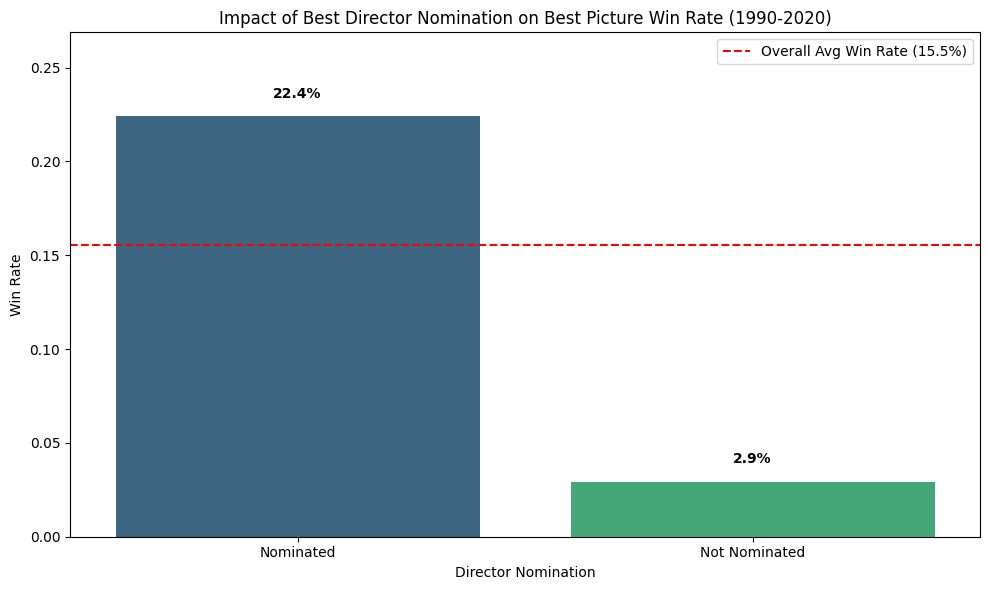

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact, chi2_contingency
import io
import warnings

# --- 0. Setup ---
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# --- 1. Data Loading and Robust Cleaning ---
# This block handles potential CSV formatting errors
try:
    with open('Final_best_picture_data.csv', 'r') as f:
        lines = f.readlines()

    cleaned_lines = []
    for line in lines:
        line = line.strip()
        if not line: continue
        # Fix rows wrapped entirely in quotes
        if line.startswith('"') and line.endswith('"'):
            content = line[1:-1].replace('""', '"')
            cleaned_lines.append(content)
        else:
            cleaned_lines.append(line)

    df = pd.read_csv(io.StringIO("\n".join(cleaned_lines)))
except FileNotFoundError:
    print("Error: 'Final_best_picture_data.csv' not found. Please upload the file.")
    df = pd.DataFrame()

if not df.empty:
    # --- 2. Preprocessing ---
    # Convert year and winner columns
    df['year_ceremony'] = pd.to_numeric(df['year_ceremony'], errors='coerce')
    df['winner'] = df['winner'].astype(str).str.lower() == 'true'

    # Filter for the analysis period (1990-2020)
    df_analysis = df[(df['year_ceremony'] >= 1990) & (df['year_ceremony'] <= 2020)].copy()

    # Create 'Has_Director_Nom' feature based on 'Nominated_Both_Director_and_Picture' column
    # Note: If a film is in this dataset (Best Picture Noms), and 'Nominated_Both...' is True,
    # it implies the director was nominated.
    df_analysis['Has_Director_Nom'] = df_analysis['Nominated_Both_Director_and_Picture'].astype(str).str.lower() == 'true'

    # --- 3. Statistical Analysis (Fisher's Exact Test) ---
    # We want to test if 'Having a Director Nomination' is dependent on 'Winning Best Picture'.
    # Since this is a categorical comparison (Yes/No vs Win/Lose), we use a contingency table.

    print("=========================================================")
    print("ANALYSIS: BEST DIRECTOR NOMINATION vs. BEST PICTURE WIN")
    print("=========================================================")

    # Construct Contingency Table
    #                  Win   Lose
    # Dir Nominated     a      b
    # Not Nominated     c      d

    dir_nom_win = len(df_analysis[(df_analysis['Has_Director_Nom']) & (df_analysis['winner'])])
    dir_nom_lose = len(df_analysis[(df_analysis['Has_Director_Nom']) & (~df_analysis['winner'])])

    no_dir_nom_win = len(df_analysis[(~df_analysis['Has_Director_Nom']) & (df_analysis['winner'])])
    no_dir_nom_lose = len(df_analysis[(~df_analysis['Has_Director_Nom']) & (~df_analysis['winner'])])

    table = [[dir_nom_win, dir_nom_lose],
             [no_dir_nom_win, no_dir_nom_lose]]

    # Perform Fisher's Exact Test
    odds_ratio, p_value = fisher_exact(table, alternative='two-sided')

    # Calculate Win Rates for clear interpretation
    total_with_nom = dir_nom_win + dir_nom_lose
    win_rate_with_nom = dir_nom_win / total_with_nom if total_with_nom > 0 else 0

    total_without_nom = no_dir_nom_win + no_dir_nom_lose
    win_rate_without_nom = no_dir_nom_win / total_without_nom if total_without_nom > 0 else 0

    # === Statistical Conclusion ===
    # Even though this is a single test here, in the context of the whole project (Genre + Runtime + etc.),
    # we should be mindful of the global alpha.
    # For this specific isolated result to be considered 'Strongly Significant', p < 0.05 is the baseline.

    alpha = 0.05
    is_significant = p_value < alpha
    significance_text = "YES (*)" if is_significant else "No"

    print(f"\n--- Group Statistics ---")
    print(f"Films WITH Director Nom:    {total_with_nom} (Winners: {dir_nom_win}, Win Rate: {win_rate_with_nom:.1%})")
    print(f"Films WITHOUT Director Nom: {total_without_nom} (Winners: {no_dir_nom_win}, Win Rate: {win_rate_without_nom:.1%})")

    print(f"\n--- Fisher's Exact Test Results ---")
    print(f"Odds Ratio: {odds_ratio:.4f} (Likelihood of winning increase)")
    print(f"P-Value:    {p_value:.6f}")
    print(f"Significant at alpha=0.05? {significance_text}")

    print("\n" + "="*30)
    print("FINAL CONCLUSION")
    print("="*30)

    if is_significant:
        print("We REJECT the Null Hypothesis.")
        print("There is a statistically significant dependency between a Best Director nomination and winning Best Picture.")
        print("Interpretation: A Best Director nomination is essentially a prerequisite for winning. Films without it have a drastically lower chance.")
    else:
        print("We FAIL TO REJECT the Null Hypothesis.")
        print("There is no statistical evidence that a Director nomination affects the outcome (Highly unlikely result).")

    # --- 4. Visualization ---
    # Prepare data for plotting
    plot_data = pd.DataFrame({
        'Director Nomination': ['Nominated', 'Not Nominated'],
        'Win Rate': [win_rate_with_nom, win_rate_without_nom]
    })

    plt.figure(figsize=(10, 6))

    # Create Bar Plot
    ax = sns.barplot(x='Director Nomination', y='Win Rate', data=plot_data, palette='viridis')

    # Add percentage labels on bars
    for i, v in enumerate([win_rate_with_nom, win_rate_without_nom]):
        ax.text(i, v + 0.01, f'{v:.1%}', ha='center', fontweight='bold')

    plt.title('Impact of Best Director Nomination on Best Picture Win Rate (1990-2020)')
    plt.ylabel('Win Rate')
    plt.ylim(0, max(win_rate_with_nom, win_rate_without_nom) * 1.2) # Add headroom

    # Add average line for context
    avg_win_rate = df_analysis['winner'].mean()
    plt.axhline(y=avg_win_rate, color='r', linestyle='--', label=f'Overall Avg Win Rate ({avg_win_rate:.1%})')
    plt.legend()

    plt.tight_layout()
    plt.show()

ANALYSIS: GOLDEN GLOBE WIN vs. BEST PICTURE WIN

--- Fisher's Exact Test Results ---
Odds Ratio: 5.5682
P-Value:    0.000045
Significant at alpha=0.05? YES (*)

CONCLUSION: REJECT H0. Winning a Golden Globe is significantly associated with winning Best Picture.


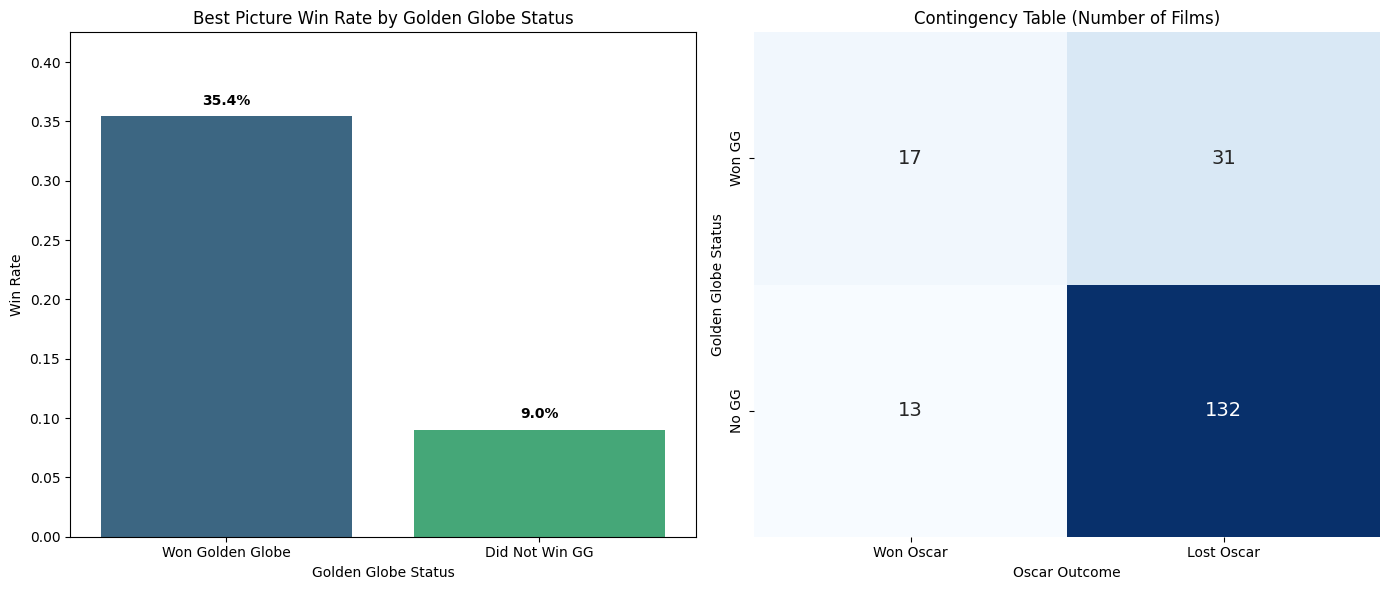

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
import io
import warnings

# --- 0. Setup ---
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# --- 1. Data Loading and Robust Cleaning ---
# This block handles potential CSV formatting errors
try:
    with open('Final_best_picture_data.csv', 'r') as f:
        lines = f.readlines()

    cleaned_lines = []
    for line in lines:
        line = line.strip()
        if not line: continue
        # Fix rows wrapped entirely in quotes
        if line.startswith('"') and line.endswith('"'):
            content = line[1:-1].replace('""', '"')
            cleaned_lines.append(content)
        else:
            cleaned_lines.append(line)

    df = pd.read_csv(io.StringIO("\n".join(cleaned_lines)))
except FileNotFoundError:
    print("Error: 'Final_best_picture_data.csv' not found. Please upload the file.")
    df = pd.DataFrame()

if not df.empty:
# --- 2. Preprocessing ---
    # Convert year and winner columns
    df['year_ceremony'] = pd.to_numeric(df['year_ceremony'], errors='coerce')
    df['winner'] = df['winner'].astype(str).str.lower() == 'true'

    # Filter for the analysis period (1990-2020)
    df_analysis = df[(df['year_ceremony'] >= 1990) & (df['year_ceremony'] <= 2020)].copy()

    # Process Golden Globe Winner column
    if 'Golden_Globe_Picture_Winner' in df_analysis.columns:
        df_analysis['Won_Golden_Globe'] = df_analysis['Golden_Globe_Picture_Winner'].astype(str).str.lower() == 'true'
    else:
        print("Error: Column 'Golden_Globe_Picture_Winner' not found. Please check column names.")
        df_analysis['Won_Golden_Globe'] = False

    # --- 3. Statistical Analysis (Fisher's Exact Test) ---
    print("=========================================================")
    print("ANALYSIS: GOLDEN GLOBE WIN vs. BEST PICTURE WIN")
    print("=========================================================")

    # Construct Contingency Table
    #                  Win Oscar   Lose Oscar
    # Won GG              a           b
    # Did Not Win GG      c           d

    gg_win_oscar_win = len(df_analysis[(df_analysis['Won_Golden_Globe']) & (df_analysis['winner'])])
    gg_win_oscar_lose = len(df_analysis[(df_analysis['Won_Golden_Globe']) & (~df_analysis['winner'])])

    no_gg_win_oscar_win = len(df_analysis[(~df_analysis['Won_Golden_Globe']) & (df_analysis['winner'])])
    no_gg_win_oscar_lose = len(df_analysis[(~df_analysis['Won_Golden_Globe']) & (~df_analysis['winner'])])

    # This is the table we will visualize in the Heatmap
    contingency_table = [[gg_win_oscar_win, gg_win_oscar_lose],
                         [no_gg_win_oscar_win, no_gg_win_oscar_lose]]

    # Perform Fisher's Exact Test
    odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')

    # Calculate Win Rates
    total_gg_winners = gg_win_oscar_win + gg_win_oscar_lose
    win_rate_gg = gg_win_oscar_win / total_gg_winners if total_gg_winners > 0 else 0

    total_no_gg = no_gg_win_oscar_win + no_gg_win_oscar_lose
    win_rate_no_gg = no_gg_win_oscar_win / total_no_gg if total_no_gg > 0 else 0

    # Conclusion
    alpha = 0.05
    is_significant = p_value < alpha
    significance_text = "YES (*)" if is_significant else "No"

    print(f"\n--- Fisher's Exact Test Results ---")
    print(f"Odds Ratio: {odds_ratio:.4f}")
    print(f"P-Value:    {p_value:.6f}")
    print(f"Significant at alpha=0.05? {significance_text}")

    if is_significant:
        print("\nCONCLUSION: REJECT H0. Winning a Golden Globe is significantly associated with winning Best Picture.")
    else:
        print("\nCONCLUSION: FAIL TO REJECT H0.")

    # --- 4. Visualization (Bar Chart + Heatmap) ---
    # Set up a figure with two side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # --- Plot 1: Bar Chart (Win Rates) ---
    plot_data = pd.DataFrame({
        'Golden Globe Status': ['Won Golden Globe', 'Did Not Win GG'],
        'Win Rate': [win_rate_gg, win_rate_no_gg]
    })

    sns.barplot(x='Golden Globe Status', y='Win Rate', data=plot_data,
                hue='Golden Globe Status', palette='viridis', ax=axes[0], legend=False)

    # Add labels
    for i, v in enumerate([win_rate_gg, win_rate_no_gg]):
        axes[0].text(i, v + 0.01, f'{v:.1%}', ha='center', fontweight='bold')

    axes[0].set_title('Best Picture Win Rate by Golden Globe Status')
    axes[0].set_ylabel('Win Rate')
    axes[0].set_ylim(0, max(win_rate_gg, win_rate_no_gg) * 1.2)

    # --- Plot 2: Heatmap (Contingency Table) ---
    # Create a DataFrame for the heatmap to have proper labels
    heatmap_df = pd.DataFrame(contingency_table,
                              index=['Won GG', 'No GG'],
                              columns=['Won Oscar', 'Lost Oscar'])

    # Draw Heatmap
    sns.heatmap(heatmap_df, annot=True, fmt='d', cmap='Blues', ax=axes[1],
                annot_kws={"size": 14}, cbar=False)

    axes[1].set_title('Contingency Table (Number of Films)')
    axes[1].set_ylabel('Golden Globe Status')
    axes[1].set_xlabel('Oscar Outcome')

    plt.tight_layout()
    plt.show()

=== PGA Award vs Oscar Winner Analysis ===

Contingency Table (Counts):
Oscar_Status    Nominee  Winner
PGA_Status                     
Not PGA Winner      197      12
PGA Winner            9      23
------------------------------
Fisher's Exact Test P-value: 0.00000
Odds Ratio: 41.95
------------------------------
CONCLUSION: There is a Statistically SIGNIFICANT relationship between winning a PGA Award and winning Best Picture.
The PGA Award is a strong predictor for the Oscar.


<Figure size 800x600 with 0 Axes>

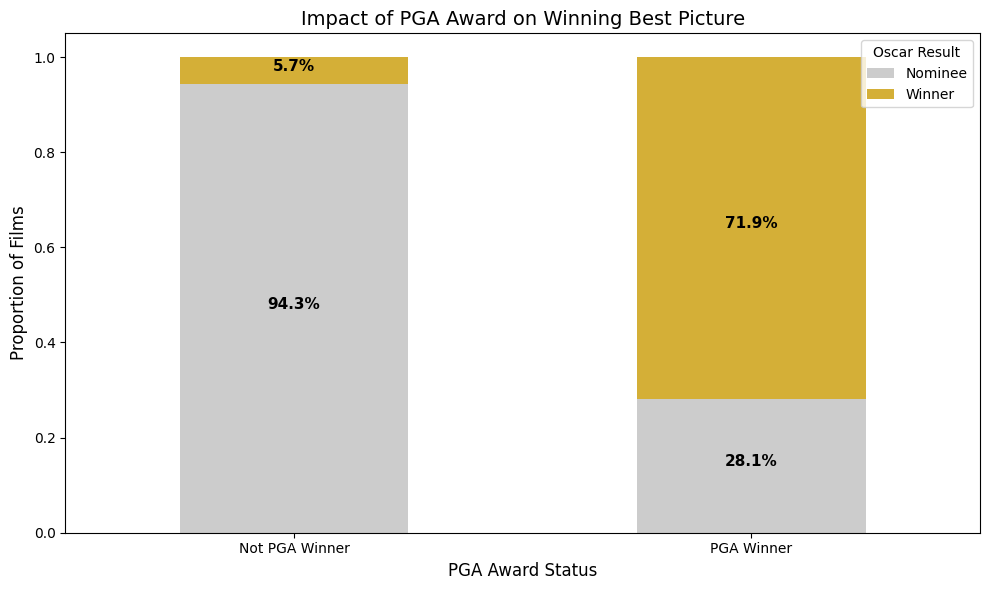

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
import io
import warnings

# --- 0. Setup ---
warnings.filterwarnings("ignore")

# --- 1. Robust Data Loading ---
# Reads the file even if it has quoting issues
try:
    with open('Final_best_picture_data.csv', 'r') as f:
        lines = f.readlines()
    cleaned_lines = []
    for line in lines:
        line = line.strip()
        if line.startswith('"') and line.endswith('"'):
            content = line[1:-1].replace('""', '"')
            cleaned_lines.append(content + '\n')
        else:
            cleaned_lines.append(line + '\n')
    csv_content = "".join(cleaned_lines)
    df = pd.read_csv(io.StringIO(csv_content))
except Exception as e:
    # Fallback to direct read if cleaning fails
    df = pd.read_csv('Final_best_picture_data.csv')

# --- 2. Data Preparation for PGA Analysis ---
# Create readable labels
df['Oscar_Status'] = df['winner'].apply(lambda x: 'Winner' if x else 'Nominee')
df['PGA_Status'] = df['pga_winner'].apply(lambda x: 'PGA Winner' if x else 'Not PGA Winner')

# Create Contingency Table
contingency_table = pd.crosstab(df['PGA_Status'], df['Oscar_Status'])

# --- 3. Statistical Test (Fisher's Exact Test) ---
# We use Fisher's Exact Test because sample sizes can be small in the "Winner" category
odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')

# --- 4. Print Results ---
print("=== PGA Award vs Oscar Winner Analysis ===")
print("\nContingency Table (Counts):")
print(contingency_table)
print("-" * 30)
print(f"Fisher's Exact Test P-value: {p_value:.5f}")
print(f"Odds Ratio: {odds_ratio:.2f}")
print("-" * 30)

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("CONCLUSION: There is a Statistically SIGNIFICANT relationship between winning a PGA Award and winning Best Picture.")
    print("The PGA Award is a strong predictor for the Oscar.")
else:
    print("CONCLUSION: There is NO statistically significant relationship (p-value >= 0.05).")

# --- 5. Visualization (Stacked Bar Chart) ---
plt.figure(figsize=(8, 6))

# Calculate percentages for the plot
cross_tab_prop = pd.crosstab(index=df['PGA_Status'],
                             columns=df['Oscar_Status'],
                             normalize="index")

# Plot
cross_tab_prop.plot(kind='bar', stacked=True, color=['#CCCCCC', '#D4AF37'], figsize=(10, 6))

plt.title('Impact of PGA Award on Winning Best Picture', fontsize=14)
plt.xlabel('PGA Award Status', fontsize=12)
plt.ylabel('Proportion of Films', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Oscar Result', loc='upper right')

# Add percentage labels
for n, x in enumerate([*cross_tab_prop.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x], cross_tab_prop.loc[x].cumsum()):
        plt.text(x=n,
                 y=(y_loc - proportion) + (proportion / 2),
                 s=f'{proportion * 100:.1f}%',
                 color="black",
                 fontsize=11,
                 fontweight="bold",
                 ha="center")

plt.tight_layout()
plt.show()